In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

X is continuous

Time on site (log-normal)

In [3]:
mu_A, mu_B, scale = 3.6, 3.5, 0.75
time_A = np.random.lognormal(mean=mu_A, sigma=scale, size=1000)
time_B = np.random.lognormal(mean=mu_B, sigma=scale, size=1000)

In [4]:
print("Mean Group A:", np.mean(time_A))
print("Mean Group B:", np.mean(time_B))

Mean Group A: 49.040457241070264
Mean Group B: 46.04138182859413


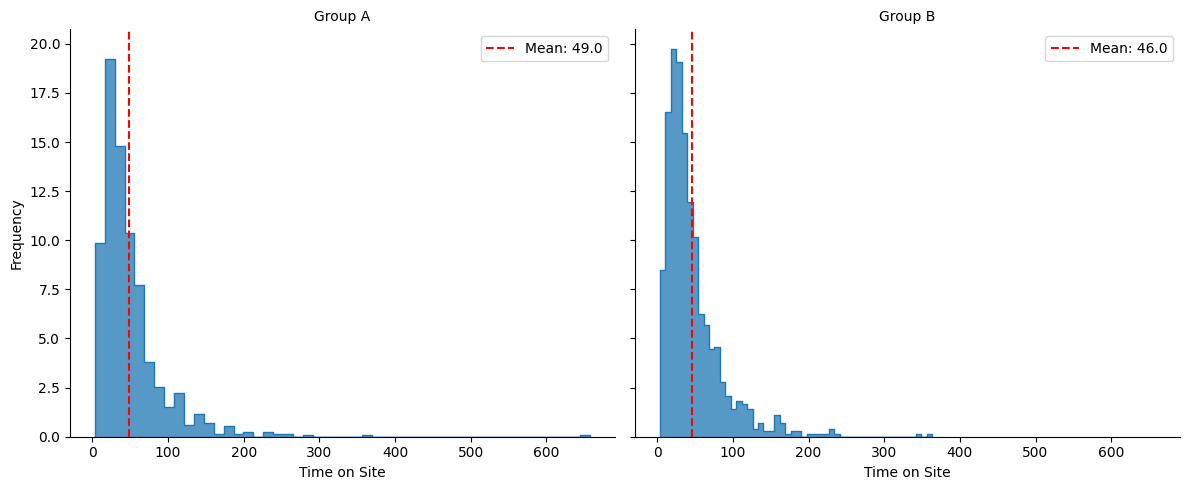

In [ ]:
# Combine into long-format DataFrame
df = pd.DataFrame({
    'Time on Site': np.concatenate([time_A, time_B]),
    'Group': ['A'] * len(time_A) + ['B'] * len(time_B)
})

# Calculate group means (for vertical lines)
group_means = df.groupby('Group')['Time on Site'].mean().to_dict()

# Create FacetGridb
g = sns.FacetGrid(df, col='Group', height=5, aspect=1.2, sharey=True)
g.map_dataframe(sns.histplot, x='Time on Site', bins=50, stat='frequency', element='step')

# Add vertical mean lines to each subplot
for ax, group in zip(g.axes.flat, group_means):
    mean_val = group_means[group]
    ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    ax.legend()

# Tweak labels
g.set_titles("Group {col_name}")
g.set_axis_labels("Time on Site", "Frequency")

plt.show()

How do we know whether the difference between the two groups is real, i.e. not due to chance?

In [10]:
# Experiment settings
n = 1000              # users per group in each experiment
num_simulations = 10000

# Collect group differences
mean_diffs = []

for _ in range(num_simulations):
    time_A = np.random.lognormal(mean=mu_A, sigma=scale, size=n)
    time_B = np.random.lognormal(mean=mu_B, sigma=scale, size=n)
    diff = np.mean(time_A) - np.mean(time_B)
    mean_diffs.append(diff)

# Convert to array for stats
mean_diffs = np.array(mean_diffs)

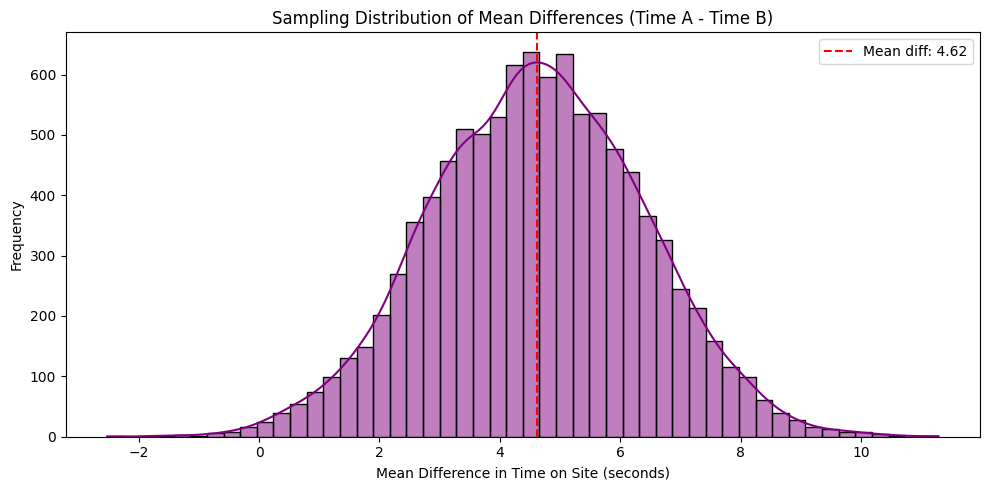

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(mean_diffs, bins=50, kde=True, color='purple')
plt.axvline(mean_diffs.mean(), color='red', linestyle='--', label=f'Mean diff: {mean_diffs.mean():.2f}')
plt.title("Sampling Distribution of Mean Differences (Time A - Time B)")
plt.xlabel("Mean Difference in Time on Site (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In practice, we would not know the real mean difference.

We only have data from one experiment, so we only know the group difference for the particular experiment that we conducted.

But we can still use the CLT.  We do this by calculating a confidence interval for the mean difference that we observed.